### ______________________________________________________________________________

<div style="width:100%;text-align: right;">
    <img src="ensae.png" /> </div>
<div style="width:100%;text-align: center;">
   <br>
    <strong style="font-size:20px;">Projet de Machine Learning</strong>
    <br>
    <br>
    ***************
    <br>
</div>

<div style="width:100%;text-align: center;">
    <img src="seattle_image.png" style="width:35%;height:100%;" /> <br>
    <span style="font-size:20px;">SEA Building Energy Benchmarking : Prediction of Building Energy <br><strong>Partie Modélisation</strong></span>
</div>

### ______________________________________________________________________________

Cette partie du projet est dédiée à la modélisation en tant que telle. Pour voir le Pré-traitement <a href="Preprocessing.ipynb" target="_blank">Cliquer ici</a>

## Sommaire du document

In [4]:
##Sommaire à remplir

In [71]:
!pip install statsmodels

In [149]:
## Importation des packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve, KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import *
from yellowbrick.model_selection import LearningCurve
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance
from yellowbrick.model_selection import ValidationCurve
import statsmodels.stats.diagnostic as smsd
import matplotlib.pyplot as plt

#### Importation de la base traitée

In [125]:
CleanedData=pd.read_csv("Clean_Data.csv")

In [3]:
CleanedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7209 entries, 0 to 7208
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   OSEBuildingID                             7209 non-null   float64
 1   DataYear                                  7209 non-null   float64
 2   NumberofFloors                            7209 non-null   float64
 3   PropertyGFABuilding(s)                    7209 non-null   float64
 4   PropertyGFAParking                        7209 non-null   float64
 5   ENERGYSTARScore                           7209 non-null   float64
 6   SiteEUI(kBtu/sf)                          7209 non-null   float64
 7   SiteEnergyUseWN(kBtu)                     7209 non-null   float64
 8   SourceEUI(kBtu/sf)                        7209 non-null   float64
 9   LargestPropertyUseTypeGFA                 7209 non-null   float64
 10  Electricity(kBtu)                   

Nous rappelons que nos variables targets sont les suivantes:

     1 - TotalGHGEmissions 
     2 - SiteEnergyUse(kBtu)

In [126]:
#### Suppression de quelques variables
var=['OSEBuildingID','ENERGYSTARScore','DataYear']
CleanedData.drop(var,inplace=True, axis=1)

Pour rappel, nos variables targets sont les suivantes:

        1. TotalGHGEmissions
        2. SiteEnergyUse(kBtu)

In [127]:
Y= CleanedData[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]
X= CleanedData.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)

### Normalité de nos variables cibles

Nos variables cibles, sont-elles normales?

In [128]:
for i in Y.columns:
    statistic, p_value = normaltest(Y[i])
    if p_value<0.05:
        print("La distribution de la variable "+i+" n'est pas normale")
    else:
        print("La distribution de la variable "+i+" est normale")

La distribution de la variable TotalGHGEmissions n'est pas normale
La distribution de la variable SiteEnergyUse(kBtu) n'est pas normale


### Que donnerait passage à l'échelle logarithmique sur les distributions des variables targets ?

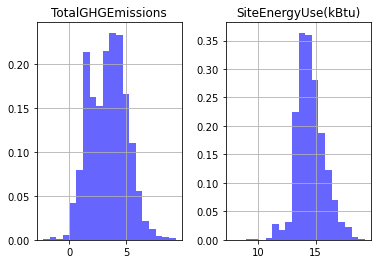

In [9]:
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
Y_log.hist(bins=20, density=True, alpha=0.6, color='b')  
plt.show()

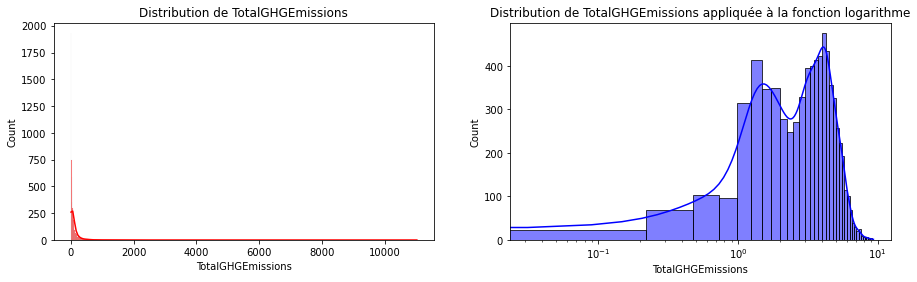

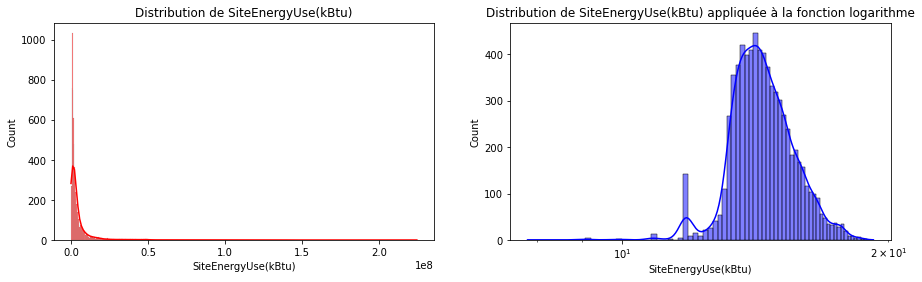

In [10]:
for i in Y.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    sns.histplot(Y[i], color='r', kde=True, ax=axes[0])
    axes[0].set_title('Distribution de '+i)

    log_y = np.log(Y[i])
    sns.histplot(log_y, color='b', kde=True, ax=axes[1])
    axes[1].set_title('Distribution de '+i+' appliquée à la fonction logarithme')
    axes[1].set_xscale('log');

L'application de la fonction s'approche de la normale mais elle ne le sont toujours pas.

In [12]:
min_values = np.min(Y, axis = 0)
max_values = np.max(Y, axis = 0)

target_normalized = (Y - min_values)/(max_values - min_values)

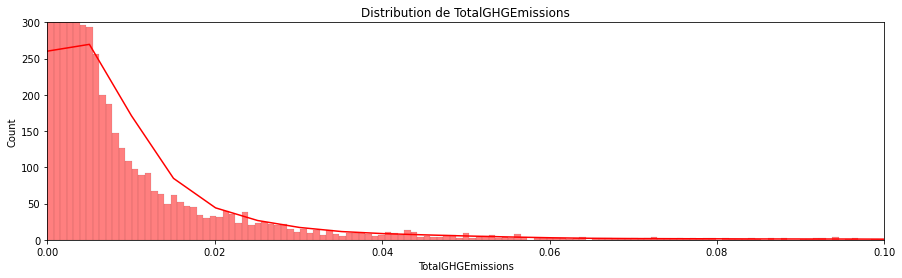

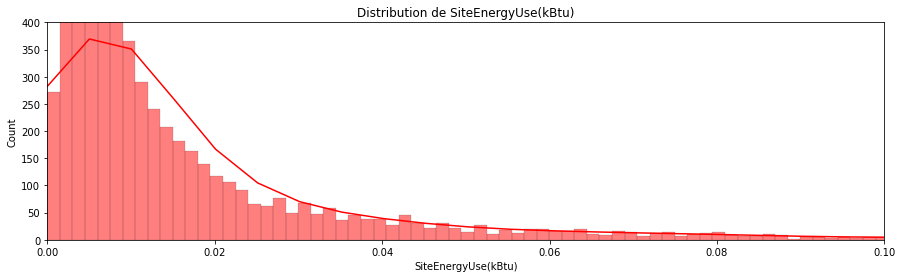

In [13]:
for i in target_normalized.columns:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    sns.histplot(target_normalized[i], color='r', kde=True, ax=axes)
    axes.set_title('Distribution de '+i)
    if i=='TotalGHGEmissions':
        b=300
    else:
        b=400
    plt.xlim(0,0.1)
    plt.ylim(0,b)

La normalisation avec la méthode du **min-max** donne également une distribution qui n'est pas normale. Nous allons à présent continuer avec la distribution obtenue en appliquant le log.

## Préparation des jeux d'entrainement et de test
Afin de tester notre meilleur modèle sur des données "inconnues", nous allons subdiviser (split) notre jeu de données en deux parties pour obtenir un jeu d'entrainement et un jeu de test (20% des données)

In [129]:
log_y=np.log(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 5767 lignes,
Test: 1442 lignes.



In [15]:
log_y.columns

Index(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], dtype='object')

In [16]:
X.columns

Index(['NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking',
       'SiteEUI(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)',
       'LargestPropertyUseTypeGFA', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'OHE_Campus', 'OHE_Multifamily',
       'OHE_NonResidential', 'OHE_SPS-District K-12',
       'OHE_Autres_Neighborhood', 'OHE_BALLARD', 'OHE_CENTRAL',
       'OHE_DELRIDGE NEIGHBORHOODS', 'OHE_DOWNTOWN', 'OHE_EAST',
       'OHE_GREATER DUWAMISH', 'OHE_LAKE UNION', 'OHE_MAGNOLIA / QUEEN ANNE',
       'OHE_NORTH', 'OHE_NORTHEAST', 'OHE_NORTHWEST', 'OHE_SOUTHEAST',
       'OHE_SOUTHWEST', 'OHE_Autres_LargestPropertyUseType',
       'OHE_Distribution Center', 'OHE_Hotel', 'OHE_K-12 School',
       'OHE_Multifamily Housing', 'OHE_Non-Refrigerated Warehouse',
       'OHE_Office', 'OHE_Other', 'OHE_Retail Store', 'OHE_Worship Facility',
       'OHE_Autres_ComplianceStatus', 'OHE_Compliant', 'OHE_Not Compliant',
       'OHE_Account Requires V

In [17]:
Y.TotalGHGEmissions.agg([min,max])

min        0.1
max    11031.5
Name: TotalGHGEmissions, dtype: float64

In [18]:
preprocessor = make_column_transformer((StandardScaler(),X.columns))

In [19]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking',
       'SiteEUI(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)',
       'LargestPropertyUseTypeGFA', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'OHE_Campus', 'OHE_Multifamily',
       'OHE_NonResidential', 'OHE_S...
       'OHE_Distribution Center', 'OHE_Hotel', 'OHE_K-12 School',
       'OHE_Multifamily Housing', 'OHE_Non-Refrigerated Warehouse',
       'OHE_Office', 'OHE_Other', 'OHE_Retail Store', 'OHE_Worship Facility',
       'OHE_Autres_ComplianceStatus', 'OHE_Compliant', 'OHE_Not Compliant',
       'OHE_Account Requires Verification', 'OHE_Autres_ComplianceIssue',
       'OHE_No Issue', 'OHE_Portfolio Manager Account Not Shared'],
      dtype='object'))])

### Régression linéaire

In [142]:
model = make_pipeline(preprocessor,LinearRegression())
model.fit(X_train,Y_train)
print("Score d'entrainement = ",model.score(X_train,Y_train))
y_pred = model.predict(X_test)
print("Score de la prédiction :", model.score(X_test, Y_test)), 
print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))

Score d'entrainement =  0.6404709503121713
Score de la prédiction : 0.6559381788298446
Ecart absolu moyen =  0.5057274029805726
Racine carrée de l'erreur quadratique moyenne =  0.6929940219151565
Erreur absolue médiane =  0.36122442570106994


Le Score d'entrainement de **0.64** montre que **notre modèle de régression linéaire** est capable de bien d'apprendre les caractéristiques des données. Il est proche du score de la prédiction qui est de **0.65** qui est également significatif. Cela nous renseigne de la performance significative de notre modèle à se généraliser à de nouvelles données et de savoir  ...

##### Essayons d'évaluons le modèle par target pour voir si elle peut être plus performante

In [143]:
for i in log_y.columns:
    X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=42)
    model = make_pipeline(preprocessor,LinearRegression())
    model.fit(X_train,Y_train)
    print(i)
    print("Score d'entrainement = ",model.score(X_train,Y_train))
    y_pred = model.predict(X_test)
    print("Score de la prédiction :", model.score(X_test, Y_test)), 
    print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
    print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
    print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))
    print("_"*75)

TotalGHGEmissions
Score d'entrainement =  0.7005565246014589
Score de la prédiction : 0.7043125272256714
Ecart absolu moyen =  0.6328044654170332
Racine carrée de l'erreur quadratique moyenne =  0.8725016662943136
Erreur absolue médiane =  0.44841836333027163
___________________________________________________________________________
SiteEnergyUse(kBtu)
Score d'entrainement =  0.6419407918817449
Score de la prédiction : 0.6508701886479524
Ecart absolu moyen =  0.5132536603534616
Racine carrée de l'erreur quadratique moyenne =  0.7102734656215517
Erreur absolue médiane =  0.359152156188399
___________________________________________________________________________


En estimant le modèle de régression linéaire pour chaque target, on constate une amélioration nette des scores (d'entrainement, de la prédiction) pour la target **TotalGHGEmissions**. Par ailleurs, même si les scores ont légèrement baissé pour la target **SiteEnergyUse(kBtu)**, les MSE, RMSE, MAE ont également baissé. Cela permet de voir que  la performance du modèle s'améliore sur la target **TotalGHGEmissions**.

A présent testons différents modèles sur notre jeux de données afin de déterminer lequel est le meilleur. 

In [28]:
# Définition des différents modèles
DiffModels = {
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor(),
    'SGDRegressor': SGDRegressor(),
    'SVR': SVR(),
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(alpha=3),
    'Lasso' : Lasso(tol=0.2),
    'ElasticNet' : ElasticNet(),
}

In [145]:
for nom_model, DModels in DiffModels.items():
    print('Algorithme: ',nom_model)
    for i in log_y.columns:
        X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=45)
        model = make_pipeline(preprocessor,DModels)
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print('Prédiction de la target ',i)
        print('Score d\'entrainement = ',model.score(X_train,Y_train))
        print("Score de la prédiction: ",  model.score(X_test, Y_test))
        mae = mean_absolute_error(Y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(Y_test,y_pred))
        med_abs_err = median_absolute_error(Y_test,y_pred)
        print("MAE = ", mae)        
        print("RMSE = ",rmse)
        print("Median abs err = ", med_abs_err)
        ##Resultats.append([nom_model, i, model.score(X_test, Y_test), mae, rmse, med_abs_err])
        print('*'*50)
    print('='*100)

Algorithme:  RandomForestRegressor
Prédiction de la target  TotalGHGEmissions
Score d'entrainement =  0.9898763992685558
Score de la prédiction:  0.9568522175189518
MAE =  0.16794972617541346
RMSE =  0.3267396670905553
Median abs err =  0.0651960112796166
**************************************************
Prédiction de la target  SiteEnergyUse(kBtu)
Score d'entrainement =  0.9872308382061517
Score de la prédiction:  0.940467600507473
MAE =  0.13012814723787483
RMSE =  0.28826236142548894
Median abs err =  0.017026665750747405
**************************************************
Algorithme:  XGBRegressor
Prédiction de la target  TotalGHGEmissions
Score d'entrainement =  0.981873955956231
Score de la prédiction:  0.950978394407583
MAE =  0.20031783902450578
RMSE =  0.34827025798308064
Median abs err =  0.09339967946926375
**************************************************
Prédiction de la target  SiteEnergyUse(kBtu)
Score d'entrainement =  0.9746028084357469
Score de la prédiction:  0.9363

#### Par constat, les meilleurs modéles sont rangées dans l'ordre suivant :

   - **RandomForestRegressor()** : il a les scores de training et de prédiction les plus élevés de tous les modèles testés. Ces scores sont respectivement (0.9899, 0.9870) -> **TotalGHGEmissions** et (0.9566, 0.9392)-> **SiteEnergyUse(kBtu)**. Ces scores sont très proches, il n'y a donc pas de phénomène de surapprentissage pour notre modèle.
   - **XGBRegressor()** : il est le deuxième meilleur modèle. Il a des scores de training et de prédiction très élevés, soit respectivement (0.9818, 0.9746) -> **TotalGHGEmissions** et (0.9509, 0.9363)-> **SiteEnergyUse(kBtu)**. Comme pour le $RandomForestRegrefssor$, le modèle de $*XGBRegressor()*$ ne surapprend pas, ses scores sont très proches.
   - **SVR()** : Ce modèle donne également de bons scores (d'entrainement et de prédiction). Ceux-ci sont supérieurs à 0.80 pour chaque target. C'est également qui n'a pas surappris.
   - **Ridge() et LinearRegression()** qui sont des modèles dont les scores sont entre 0.60 et 0.75. Ce sont également des modèles performants dans le cadre de ce projet.

Dans la suite, nous essayerons d'optimiser les hyperparamètres du **RandomForestRegressor()** qui est notre meilleur modèle. Mais puisque ce modèle est déja très performant (il a un R2 score très élevé et des métrics de calculs d'erreurs très faibles), nous ferons en même temps le tuning des hyperparamètres pour le modèle **Ridge** afin d'observer les effet du tuning des hyperparamètres et voir si l'on peut le rendre encore plus performant.

### RandomForest()

### Test du Random forest en considérant les deux targets en même temps

In [154]:
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)
model = make_pipeline(preprocessor,RandomForestRegressor())
model.fit(X_train,Y_train)
print("Score d'entrainement = ",model.score(X_train,Y_train))
y_pred = model.predict(X_test)
print("Score de la prédiction :", model.score(X_test, Y_test)), 
print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))

Score d'entrainement =  0.9886942383775514
Score de la prédiction : 0.9418753587405378
Ecart absolu moyen =  0.15557774700621801
Racine carrée de l'erreur quadratique moyenne =  0.3352294259393412
Erreur absolue médiane =  0.041099536211281484


### Tuning des hyperparamètres

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=45)
param_grid = {'n_estimators': [10, 50, 100, 200],
             'max_depth' : [None, 5, 10, 15],
             'min_samples_split': [2, 5, 10, 15],
             'min_samples_leaf' : [1, 2, 4, 6]}
rand_forest = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rand_forest, param_grid = param_grid, cv = 5, 
                           n_jobs = -1, verbose = 2)
grid_search.fit(X_train, Y_train)
print('Les meilleures paramètres pour les targets')
print(grid_search.best_params_)
print("*"*80)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Les meilleures paramètres pour les targets
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
********************************************************************************


In [155]:
y_pred = grid_search.best_estimator_.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
rmse_test = np.sqrt(MSE(Y_test, y_pred))
print("rmse_test: ", np.round(rmse_test, 2))
print("Score d'entrainement", grid_search.best_estimator_.score(X_train,Y_train))
print("Score pour la prédiction", grid_search.best_estimator_.score(X_test, Y_test))

rmse_test:  0.21
Score d'entrainement 0.981149607035913
Score pour la prédiction 0.9787023313247236


### Courbe d'apprentissage du modèle RandomForestRegressor() ?

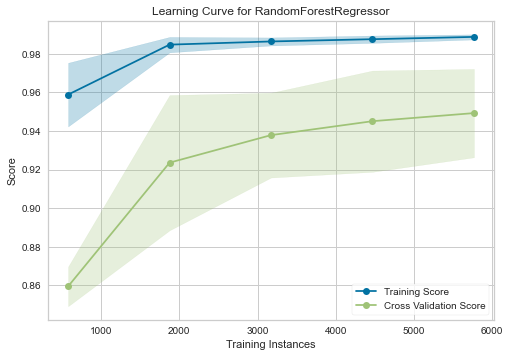

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [156]:
visualizer = LearningCurve(RandomForestRegressor(n_estimators=200, random_state=42), scoring='r2', random_state=42)

visualizer.fit(X, log_y)        # Fit the data to the visualizer
visualizer.show()

L'utilité de cette courbe est qu'elle montre la performance du modèle sur les données d'entraînement en fonction de la quantité de données d'entraînement utilisées. Elle est utilisée pour déterminer si le modèle est capable d'apprendre à partir des données d'entraînement et si la performance du modèle est suffisante. En général, on s'attend à ce que la performance du modèle sur les données d'entraînement augmente avec la quantité de données d'entraînement utilisées, car plus il y a de données d'entraînement, plus le modèle a l'occasion de s'ajuster.

La figure ci-dessus montre qu'à partir d'une taille des données d'entrainement de 2000, le modèle n'apprend plus la performance du modèle ne s'accroît plus.

In [157]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cv

KFold(n_splits=5, random_state=1, shuffle=True)

### Ridge()

In [79]:
for i in Y.columns:
    X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=45)
    param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}

    model = Ridge()

    grid_search2 = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

    grid_search2.fit(X_train, Y_train)
    
    print("For ",i)
    print(grid_search2.best_params_)
    y_pred = grid_search2.best_estimator_.predict(X_test)
    rmse_test = np.sqrt(MSE(Y_test, y_pred))
    print("RMSE : ", np.round(rmse_test, 2))
    print("Score d'entrainement", grid_search2.best_estimator_.score(X_train,Y_train))
    print("Score pour la prédiction", grid_search2.best_estimator_.score(X_test, Y_test))
    if i=="TotalGHGEmissions":
        a=pd.DataFrame(y_pred)
        a.index=Y_test.index
        a.columns=["Y_predicted"]
        a=pd.concat([Y_test,a],axis=1)
        a["MSE"]=abs(a.iloc[:,0]-a.iloc[:,1])/a.shape[0]
    else:
        b=pd.DataFrame(y_pred)
        b.index=Y_test.index
        b.columns=["Y_predicted"]
        b=pd.concat([Y_test,b],axis=1)
        b["MSE"]=abs(b.iloc[:,0]-b.iloc[:,1])/b.shape[0]
    print("="*75)
    print(a)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.65022e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.6896e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.77779e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.71157e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning

For  TotalGHGEmissions
{'alpha': 5}
RMSE :  0.84
Score d'entrainement 0.697917637898162
Score pour la prédiction 0.7157128403270534
      TotalGHGEmissions  Y_predicted       MSE
6175           2.442347     3.425329  0.000682
2126           4.317488     3.930151  0.000269
1160           4.410371     5.090253  0.000471
6318           1.252763     1.226124  0.000018
6809           4.067316     4.924920  0.000595
...                 ...          ...       ...
1839           2.001480     2.103193  0.000071
1758           2.406945     1.895146  0.000355
729            3.883624     5.619356  0.001204
7104           3.198673     3.078666  0.000083
3019           4.426044     4.794780  0.000256

[1442 rows x 3 columns]


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.65022e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.6896e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.77779e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.71157e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning

For  SiteEnergyUse(kBtu)
{'alpha': 5}
RMSE :  0.69
Score d'entrainement 0.6403365570268233
Score pour la prédiction 0.6569072622160439
      TotalGHGEmissions  Y_predicted       MSE
6175           2.442347     3.425329  0.000682
2126           4.317488     3.930151  0.000269
1160           4.410371     5.090253  0.000471
6318           1.252763     1.226124  0.000018
6809           4.067316     4.924920  0.000595
...                 ...          ...       ...
1839           2.001480     2.103193  0.000071
1758           2.406945     1.895146  0.000355
729            3.883624     5.619356  0.001204
7104           3.198673     3.078666  0.000083
3019           4.426044     4.794780  0.000256

[1442 rows x 3 columns]


Définissons à présent un cross validation sur nos deux modèles

Le grid search nous propose comme meilleur paramètre **alpha 5** pour le modèle **Ridge()**.
Et nous constatons également une très légère amélioration des scores d'entrainement et de prédiction pour les deux targets.

### Prédiction et tabulation de quelques valeurs avec la métrique MSE

In [111]:
a.MSE.max()

0.002759164655333169

Text(0.5, 1.0, 'Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$')

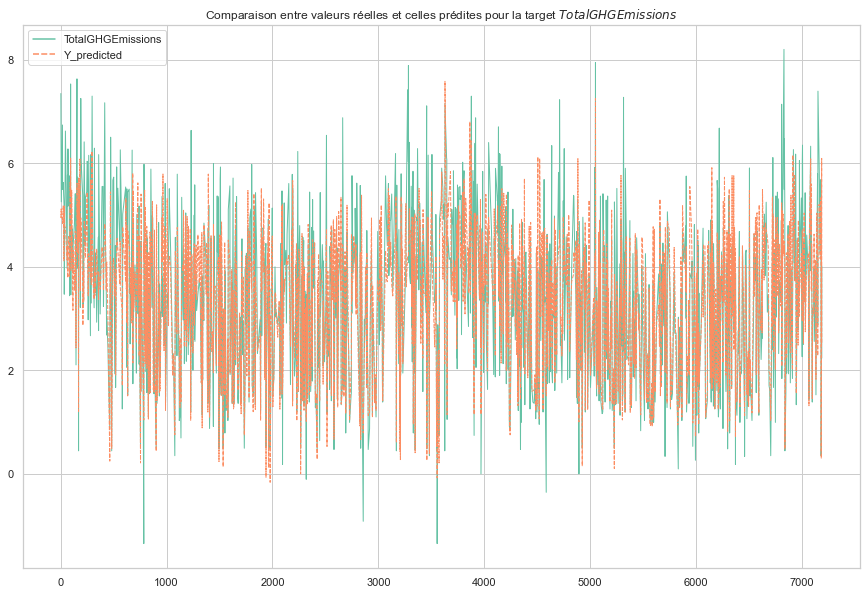

In [102]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.lineplot(data=a[['TotalGHGEmissions','Y_predicted']],palette="Set2", linewidth=1)
plt.title("Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$")

Text(0.5, 1.0, 'Comparaison entre valeurs réelles et celles prédites pour la target $SiteEnergyUse(kBtu)$')

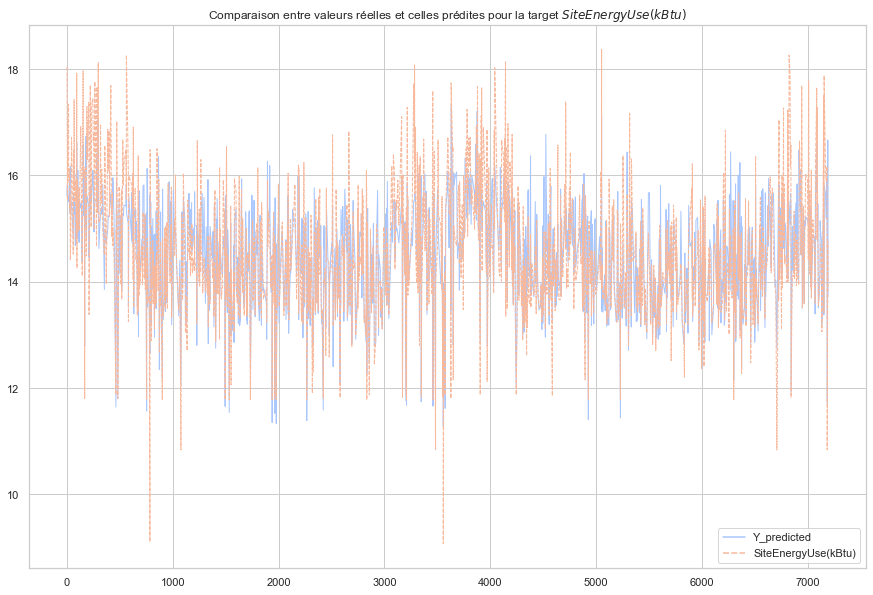

In [115]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.lineplot(data=b[['Y_predicted','SiteEnergyUse(kBtu)']], palette="coolwarm", linewidth=1)
plt.title("Comparaison entre valeurs réelles et celles prédites pour la target $SiteEnergyUse(kBtu)$")

Nous constatons effectivement que Ridge fait de bonnes prédictions.